<a href="https://colab.research.google.com/github/r-dube/CICIDS/blob/main/ids_heartbleed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Load the top modules that are used in multiple places
import numpy as np
import pandas as pd

In [4]:
# Some global variables to drive the script
# data_url is the location of the data
# Data is not loaded from a local file
# Data is loaded from a prepocessed dataset
data_url="https://raw.githubusercontent.com/r-dube/CICIDS/main/MachineLearningCVE/processed/heartbleed-cicids2017.csv"

In [5]:
# label names (YY) in the data and their
# mapping to numerical values
label_map = {
 'BENIGN' : 0,
 'FTP-Patator' : 1,
 'SSH-Patator' : 2,
 'DoS slowloris' : 3,
 'DoS Slowhttptest': 4,
 'DoS Hulk' : 5,
 'DoS GoldenEye' : 6,
 'Heartbleed' : 7,
 'Web Attack � Brute Force' : 8,
 'Web Attack � XSS' : 8,
 'Web Attack � Sql Injection' : 8,
 'Infiltration' : 9,
 'Bot' : 10,
 'PortScan' : 11,
 'DDoS' : 12,
}

num_ids_features = 76
num_ids_classes = 13
ids_classes = [ 'BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed', 'Brute Force', 'XSS', 'Sql Injection', 'Infiltration', 'Bot', 'PortScan', 'DDoS',]

In [6]:
# Utility functions
def ids_load_df_from_csv():
    """
    Load dataframe from csv file
    Input:
        None
    Returns:
        None
    """

    df = pd.read_csv(data_url)

    # uncomment print statements for debugging if data does not load
    # print ("load Dataframe shape", df.shape)

    return df

def ids_array(df):
    """
    Return numpy arrays from dataframe
    Input:
        Dataframe that has columns of covariates followed by a column of labels
    Returns:
        X, y as numpy arrays
    """
    numcols = len(df.columns)

    X = df.iloc[:, 0:numcols-1]
    y = df.loc[:, 'YY']

    X = X.values
    y = y.values

    return X, y

def ids_isof_create(df, attack):
    """
    Return negative and positive prediction counts
    Input:
        datframe to be split
        attack class to be used for splitting
    Returns:
        dataframes X_in (for training), X_out (for testing)
          X_out contains the same number of attack and benign samples
    """
    df_Xout = df[df.YY == attack]
    samples = df_Xout.shape[0]

    df_Xin = df[df.YY == 0]

    df_Xout = df_Xout.append(df_Xin.tail(samples))
    df_Xin = df_Xin.head(-samples)

    return df_Xin, df_Xout

def ids_isof_accuracy(y_actual, y_pred):
    """
    Return metrics on isolation forest classification performance
    Input:
        y_actual - numpy array containing {1, -1} values
        y_pred - numpy array containing {1, -1} predictions from isolation forest
    Returns:
        Accuracy, false positive rate, false negative rate between 0 and 1
    """
    samples = y_actual.size
    acc = (np.sum(y_actual == y_pred))/samples
    fp = (np.sum((y_actual == 1) & (y_pred == -1)))/samples
    fn = (np.sum((y_actual == -1) & (y_pred == 1)))/samples
    return acc, fp, fn

In [7]:
# Use Isolation forest to detect heartbleed
from sklearn.ensemble import IsolationForest

df = ids_load_df_from_csv ()
df_Xin, df_Xout = ids_isof_create(df, attack=7)

Xin, yin = ids_array(df_Xin)
Xout, yout = ids_array(df_Xout)

isof = IsolationForest(random_state=42).fit(Xin)
y_pred = isof.predict(Xout)

yout = np.where(yout == 7, -1, 1)
acc, fp, fn = ids_isof_accuracy(yout, y_pred)
print ("Accuracy", acc, "FP rate", fp, "FN rate", fn)

Accuracy 0.9090909090909091 FP rate 0.09090909090909091 FN rate 0.0


In [8]:
# Use PCA to visualize data
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

X, y = ids_array(df)
pca = PCA(n_components=6)
X2 = pca.fit_transform(X)

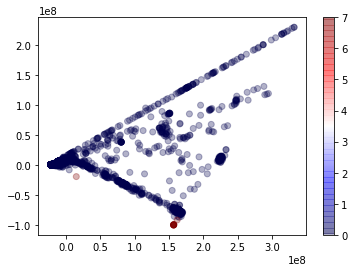

In [9]:
plt.scatter(X2[:, 0], X2[:, 1], c=y, alpha=0.3, cmap='seismic')
plt.colorbar();

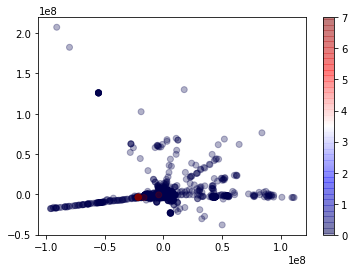

In [10]:
plt.scatter(X2[:, 2], X2[:, 3], c=y, alpha=0.3, cmap='seismic')
plt.colorbar();

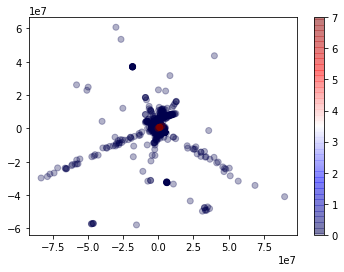

In [11]:
plt.scatter(X2[:, 4], X2[:, 5], c=y, alpha=0.3, cmap='seismic')
plt.colorbar();

In [20]:
# Re-run isolation forest with a modified version of the two-class dataset
data_url="https://raw.githubusercontent.com/r-dube/CICIDS/main/MachineLearningCVE/processed/twoclass-cicids2017.csv"
df = ids_load_df_from_csv ()

# retain only samples rows of attack class
attack = 11
samples = 11
df_Xout = df[df.YY == attack]
df_Xout = df_Xout.head(samples)
df_Xin = df[df.YY == 0]
df_Xout = df_Xout.append(df_Xin.tail(samples))
df_Xin = df_Xin.head(-samples)

Xin, yin = ids_array(df_Xin)
Xout, yout = ids_array(df_Xout)

isof = IsolationForest(random_state=42).fit(Xin)
y_pred = isof.predict(Xout)

yout = np.where(yout == attack, -1, 1)
acc, fp, fn = ids_isof_accuracy(yout, y_pred)
print ("Accuracy", acc, "FP rate", fp, "FN rate", fn)

Accuracy 0.4090909090909091 FP rate 0.09090909090909091 FN rate 0.5
